In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
os.chdir("gdrive/My Drive/")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


FileNotFoundError: ignored

In [0]:
# import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from numpy import array

In [0]:
#load the dataset from url
URL_Tr= 'https://raw.githubusercontent.com/cacoderquan/Sentiment-Analysis-on-the-Rotten-Tomatoes-movie-review-dataset/master/train.tsv'
dataset = pd.read_csv(URL_Tr, sep='\t')
print(dataset.shape)
dataset.head()

(156060, 4)


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


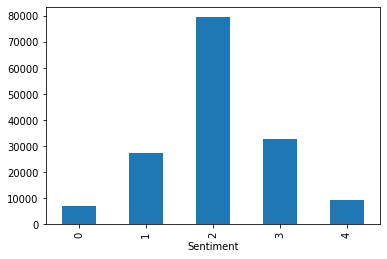

In [0]:
# plot graph by sentiment
import matplotlib.pyplot as plt
dataset.groupby('Sentiment').Phrase.count().plot.bar(ylim=0)
plt.show()

In [0]:
dataset.shape

(156060, 4)

In [0]:
numSentences = dataset['SentenceId'].max()

In [0]:
# extract full sentences only from the dataset
fullSentences = []
curSentence = 0
for i in range(dataset.shape[0]):
  if dataset['SentenceId'][i]> curSentence:
    fullSentences.append((dataset['Phrase'][i], dataset['Sentiment'][i]))
    curSentence = curSentence +1

In [0]:
len(fullSentences)

8544

In [0]:
# put data into a dataframe
fullSentDf = pd.DataFrame(fullSentences, columns=['Phrase', 'Sentiment'])

In [0]:
# Check class imbalance in tokenized sentences
dataset['Sentiment'].value_counts()

2    79582
3    32927
1    27273
4     9206
0     7072
Name: Sentiment, dtype: int64

In [0]:
# Check class imbalance in full sentences
fullSentDf['Sentiment'].value_counts()

3    2325
1    2203
2    1659
4    1282
0    1075
Name: Sentiment, dtype: int64

In [0]:
import nltk
import random
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:
documents = []
#convert data into format

#use full dataset
for i in range(dataset.shape[0]):
  tmpWords = word_tokenize(dataset['Phrase'][i])
  documents.append((tmpWords, dataset['Sentiment'][i]))

# Use only complete sentences
# for i in range(fullSentDf.shape[0]):
#   tmpWords = word_tokenize(fullSentDf['Phrase'][i])
#   documents.append((tmpWords, fullSentDf['Sentiment'][i]))

In [0]:
random.seed(9001)
random.shuffle(documents)
print(documents[1][0])

['can', 'only', 'remind', 'us', 'of', 'brilliant', 'crime', 'dramas', 'without', 'becoming', 'one', 'itself', '.']


In [0]:
len(documents)

156060

In [0]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer, LancasterStemmer
from nltk.stem.snowball import SnowballStemmer
porter = PorterStemmer()
lancaster=LancasterStemmer()
snowball = SnowballStemmer("english")
wordnet_lemmatizer = WordNetLemmatizer()
stopwords_en = stopwords.words("english")
punctuations="?:!.,;'\"-()"

#parameters to adjust to see the impact on outcome
remove_stopwords = True
useStemming = True
useLemma = False
removePuncs = True

for l in range(len(documents)):
  label = documents[l][1]
  tmpReview = []
  for w in documents[l][0]:
    newWord = w
    if remove_stopwords and (w in stopwords_en):
      continue
    if removePuncs and (w in punctuations):
      continue
    if useStemming:
      # newWord = porter.stem(newWord)
      newWord = lancaster.stem(newWord)
      # newWord = snowball.stem(newWord)
    if useLemma:
      newWord = wordnet_lemmatizer.lemmatize(newWord)
    tmpReview.append(newWord)
  documents[l] = (' '.join(tmpReview), label)
print(documents[0])

('lot recommend read my lip', 4)


In [0]:
all_data = pd.DataFrame(documents, columns=['text', 'sentiment'])
# Splits the dataset so 70% is used for training and 30% for testing
x_train_raw, x_test_raw, y_train_raw, y_test_raw = train_test_split(all_data['text'], all_data['sentiment'], test_size=0.3, random_state=2003)

In [0]:
len(x_train_raw)

109242

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

vector_size = 2500

# Transform each text into a vector of word counts
# vectorizer = CountVectorizer(max_features = vector_size,stop_words="english", ngram_range=(1, 2))

vectorizer = TfidfVectorizer(max_features = vector_size, stop_words = "english", ngram_range = (1, 2))
#X = vectorizer.fit_transform(all_data["text"])
#Y = all_data['sentiment']
x_train = vectorizer.fit_transform(x_train_raw).toarray()
y_train = y_train_raw
x_test = vectorizer.transform(x_test_raw).toarray()
y_test = y_test_raw

y_test = np.array(y_test)
y_test = y_test.reshape(y_test.shape[0],1)

In [0]:
# # x_train = x_train.transform(x_train)  #both of the methods have the same representation bcz of the same sparse method
# # x_test = x_test.transform(x_test)

# # x_train = x_train.transform(x_train).toarray()# same as method 1 that is BOW
# # x_test = x_test.transform(x_test).toarray()
# print(x_train.shape)
# print(x_test.shape)

x_train = np.array(x_train)
x_train = x_train.reshape(x_train.shape[0], vector_size, 1)
print(x_train.shape)

x_test = np.array(x_test)
x_test = x_test.reshape(x_test.shape[0], vector_size, 1)
print(x_test.shape)

(109242, 2500, 1)
(46818, 2500, 1)


In [0]:
from keras.utils import to_categorical 

# conveting the array into one vector
y_train = to_categorical(y_train)
y_train.shape

#converting the array into matrix
y_train[0:5,]

array([[0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)

In [0]:
from keras import backend as K
# defining the recall method
def recall_value(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true*y_pred, 0, 1))) 
  possible_positives = K.sum(K.round(K.clip(y_true, 0 ,1)))
  recall = true_positives / (possible_positives + K.epsilon())
  return recall

In [0]:
# defining the precision method
def precision_value(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true*y_pred, 0, 1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0 ,1)))
  precision = true_positives / (predicted_positives + K.epsilon())
  return precision

In [0]:
# defining the f1 score method
def f1_score(y_true, y_pred):
  precision = precision_value(y_true, y_pred)
  recall = recall_value(y_true, y_pred)
  return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [0]:
from keras.models import Sequential
from keras.layers import MaxPooling1D, Dense, Dropout, Flatten
from keras.layers import Activation, Conv1D

# build cnn model
# defining the cnn model
def cnn_model(fea_matrix, n_class, compiler):
  # setting the model as sequential one
  model = Sequential()
  model.add(Conv1D(filters=128, kernel_size=3, activation='tanh', input_shape=(fea_matrix.shape[1], fea_matrix.shape[2])))
  model.add(MaxPooling1D(pool_size=1))
  model.add(Dropout(rate = 0.25))
  model.add(Conv1D(filters=64, kernel_size=5, activation='tanh'))
  model.add(MaxPooling1D(pool_size=1))
  model.add(Dropout(rate = 0.25))
  model.add(Conv1D(filters=32, kernel_size=5, activation='tanh'))
  model.add(MaxPooling1D(pool_size=1))
  model.add(Dropout(rate = 0.25))
  model.add(Flatten())
  model.add(Dense(16, activation='tanh'))
  model.add(Dense(n_class, activation='softmax'))
  model.compile(optimizer=compiler, loss='categorical_crossentropy',
                  metrics=['acc', f1_score, precision_value, recall_value])

  return model

In [0]:
from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.utils import class_weight

num_epochs = 100
batch_size = 256
decay = 1e-4
n_class = 5

#defining the different optimizers

adam = optimizers.Adam(lr = 0.007)

sgd = optimizers.SGD(lr = 1e-3, 
                     nesterov=True,
                     momentum=0.7) 

Nadam = optimizers.Nadam(lr = 1e-3, 
                         beta_1 = 0.9, 
                         beta_2 = 0.999,
                         epsilon = 1e-08)

model = cnn_model(x_train, n_class, Nadam)

es = EarlyStopping(monitor='val_acc', 
                   mode='max', patience=3)

model.fit(x_train, y_train, 
          batch_size = batch_size,
          epochs = num_epochs, 
          validation_split=  0.2, 
          class_weight='auto',
          callbacks=[es])

Train on 87393 samples, validate on 21849 samples
Epoch 1/100
87393/87393 [==============================] - 39s 444us/step - loss: 1.1182 - acc: 0.5601 - f1_score: 0.4866 - precision_value: 0.6037 - recall_value: 0.4164 - val_loss: 0.9982 - val_acc: 0.6040 - val_f1_score: 0.5703 - val_precision_value: 0.6538 - val_recall_value: 0.5060
Epoch 2/100
87393/87393 [==============================] - 38s 431us/step - loss: 0.9649 - acc: 0.6158 - f1_score: 0.5797 - precision_value: 0.6755 - recall_value: 0.5081 - val_loss: 0.9769 - val_acc: 0.6145 - val_f1_score: 0.5801 - val_precision_value: 0.6739 - val_recall_value: 0.5095
Epoch 3/100
87393/87393 [==============================] - 38s 431us/step - loss: 0.9215 - acc: 0.6336 - f1_score: 0.6045 - precision_value: 0.6892 - recall_value: 0.5388 - val_loss: 0.9651 - val_acc: 0.6229 - val_f1_score: 0.5910 - val_precision_value: 0.6761 - val_recall_value: 0.5252
Epoch 4/100
87393/87393 [==============================] - 38s 430us/step - loss: 0.89

In [0]:
#printing the metrics of accuracy, presision and F1 score
def print_metrics(accuarcy, f1_score, precision, recall):
  print('Accuarcy:',np.round(accuracy, 4))
  print('precision:',np.round(precision, 4))
  print('Recall:',np.round(recall, 4))
  print('F1 Score:',np.round(f1_score, 4))

In [0]:
from keras.models import load_model

model.save('1095526_1dconv_reg.h5')

print("----------------------------")
# returns a compiled model
# identical to the previous one
loaded_model = load_model('1095526_1dconv_reg.h5', custom_objects = {'f1_score' : f1_score, 'precision_value' : precision_value, 'recall_value' : recall_value})

----------------------------


In [0]:
# conveting the array into one vector
y_test = to_categorical(y_test)
y_test.shape

y_test[0:5,]

loss, accuracy, f1_score, precision_value, recall_value = loaded_model.evaluate(x_test, y_test, verbose=0)
print_metrics(accuracy, f1_score, precision_value, recall_value)

Accuarcy: 0.6215
precision: 0.6577
Recall: 0.5558
F1 Score: 0.6016
